<a href="https://colab.research.google.com/github/tmp-friends/survey-stable-diffusion/blob/main/oreilly_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データセット

### データセットのロード

Hugging Face Datasetsを用いて、ロードしていく

In [2]:
!pip install datasets pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 8.1 MB/s 
     |████████████████████████████████| 212 kB 68.3 MB/s 
     |████████████████████████████████| 95 kB 6.2 MB/s 
     |████████████████████████████████| 115 kB 73.9 MB/s 
     |████████████████████████████████| 163 kB 65.7 MB/s 
     |████████████████████████████████| 127 kB 70.8 MB/s 
     |████████████████████████████████| 115 kB 70.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [3]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f'There are {len(all_datasets)} datasets currently available on the Hub')
print(f'The first 10 are: {all_datasets[:10]}')

There are 13182 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
from datasets import load_dataset

emotions = load_dataset('emotion')

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
print(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [6]:
train_ds = emotions['train']

print(train_ds[0])
print(train_ds.features)

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


#### 自分のデータセットを使うには

- CSV: `load_dataset('csv', data_files='my_file.csv')`

### データ観察

In [9]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


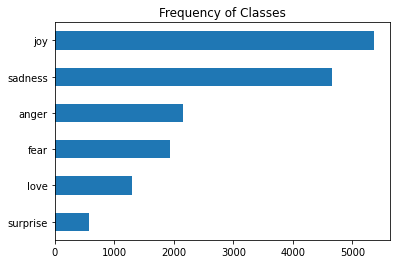

In [10]:
import matplotlib.pyplot as plt

# クラスごとのサンプル数を調べる
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


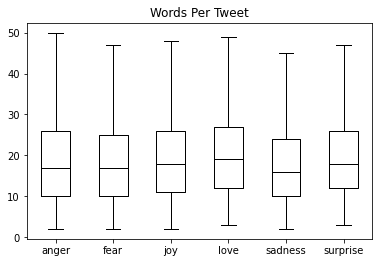

In [11]:
# テキストの最大長を調べる
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

In [13]:
emotions.reset_format()

## テキストのトークン化

種類
- 文字トークン化
- 単語トークン化
- サブワードトークン化

### 文字トークン化

- 文字に分割
  - (Pythonのstrオブジェクトは実は配列なので、容易に実装可)

- メリット
  - テキストの構造を一切無視して、文字列全体を文字のストリームとして扱える
- デメリット
  - 単語のような言語構造をデータから学習する必要がある
    - 膨大な計算量
    - 膨大なメモリ
    - 膨大なデータ　が必要となってくる

In [14]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
text = 'Tokenizing text is a core task of NLP'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P']


In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, 'L': 1, 'N': 2, 'P': 3, 'T': 4, 'a': 5, 'c': 6, 'e': 7, 'f': 8, 'g': 9, 'i': 10, 'k': 11, 'n': 12, 'o': 13, 'r': 14, 's': 15, 't': 16, 'x': 17, 'z': 18}


In [17]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[4, 13, 11, 7, 12, 10, 18, 10, 12, 9, 0, 16, 7, 17, 16, 0, 10, 15, 0, 5, 0, 6, 13, 14, 7, 0, 16, 5, 15, 11, 0, 13, 8, 0, 2, 1, 3]


In [18]:
import torch
import torch.nn.functional as F

# one-hotエンコーディング
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([37, 19])

In [19]:
print(f'Token: {tokenized_text[0]}')
print(f'Tensor index: {input_ids[0]}')
print(f'One-hot: {one_hot_encodings[0]}')

Token: T
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### 単語トークン化

- 単語に分割
- メリット
  - 単語単位のため、文字から単語を学習するステップを省略可
- デメリット
  - 語彙数が膨大になる
  - 語彙数を制限して、頻出単語を扱うとしても性能に悪影響

In [20]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP']


### サブワードトークン化

文字トークン化と単語トークン化のいいところを組み合わせる
統計的ルールとアルゴリズムを組み合わせ、**事前学習用のコーパス**からトークン化を学習する

- 頻出単語: 一意なものとして管理
- 稀な単語: より小さな単語に分割し、複雑な単語やスペルを処理できるようにする

In [21]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 6.4 MB/s 
     |████████████████████████████████| 7.6 MB 53.6 MB/s 


In [22]:
# WordPiece - BERT, DistilBERTのトークナイザーとして使われている
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [23]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [24]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [25]:
print(tokenizer.convert_tokens_to_string(tokens))
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

[CLS] tokenizing text is a core task of nlp [SEP]
30522
512
['input_ids', 'attention_mask']


### データセット全体のトークン化

In [26]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [27]:
print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [28]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [29]:
print(emotions_encoded['train'].column_names)
print(len(emotions_encoded['train']))

['text', 'label', 'input_ids', 'attention_mask']
16000


## 学習

事前学習済みモデルを分類タスクに使用するには、2通りの方法
- 特徴抽出
  - 隠れ状態を特徴として利用し、分類器を学習
  - 事前学習済みモデルは更新しない
- ファインチューニング
  - モデル全体をエンドツーエンドで学習
  - 事前学習済みモデルのパラメータも更新


### 特徴抽出

特徴抽出器としてTransformerを使う

- 学習時にボディの重みを凍結し、隠れ状態を分類器の特徴として利用

- メリット
  - 小さいモデルを素早く学習可

In [30]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### [実験] 最後の隠れ状態を抽出（1つのテキスト）

In [31]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(inputs['input_ids'])

Input tensor shape: torch.Size([1, 6])
tensor([[ 101, 2023, 2003, 1037, 3231,  102]])


In [32]:
inputs = {key: value.to(device) for key, value in inputs.items()}

# 勾配の自動計算無効
with torch.no_grad():
  # **<変数> で辞書型のスプリット演算子の意味
  # *<変数> は辞書型でないスプリット演算子
  outputs = model(**inputs)

# 最後の隠れ状態のOutputs
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [33]:
# [batch_size, n_tokens, hidden_dim]の形
print(outputs.last_hidden_state.size())
# [CLS]トークンに関連付けられた隠れ状態を確認
print(outputs.last_hidden_state[:,0].size())

torch.Size([1, 6, 768])
torch.Size([1, 768])


#### [実験] 最後の隠れ状態を抽出（データセット全体）

In [34]:
def extract_hidden_states(batch):
  # モデルの入力をGPU上へ配置
  inputs = {key: value.to(device) for key, value in batch.items() if key in tokenizer.model_input_names}
  # 最後の隠れ状態を抽出
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # [CLS]トークンに対するベクトルを返す
  return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}

In [35]:
# モデルの入力はテンソルを想定しているので、torch形式に変換
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [36]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [40]:
print(emotions_hidden['train'].column_names)
print(emotions_hidden['train']['hidden_state'])

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']
tensor([[-0.1168,  0.0986, -0.1296,  ...,  0.0587,  0.3543,  0.4042],
        [-0.0324, -0.0323, -0.1957,  ..., -0.1747,  0.3546,  0.3028],
        [ 0.0397,  0.2022,  0.1423,  ..., -0.1141,  0.3394,  0.3958],
        ...,
        [-0.0034, -0.0959,  0.0584,  ..., -0.0427,  0.2496,  0.3076],
        [ 0.0666,  0.1733,  0.1290,  ...,  0.0612,  0.2904,  0.4684],
        [ 0.0167,  0.1013, -0.0073,  ..., -0.0649,  0.3454,  0.2199]])


#### 特徴行列の作成

- 入力特徴量: 出力した隠れ状態
- ターゲット: ラベル


In [ ]:
!pip install numpy

In [41]:
import numpy as np

X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

print(X_train.shape, X_valid.shape)

(16000, 768) (2000, 768)


#### 学習データセットの可視化

In [51]:
!pip install umap-learn sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.6 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=13fb8606ad274493fc98ddfe4c8e1e07627dd196463abf9c3e81a2f69a1bf308
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=fd5d50ce320eb0f916490381f7c76be2dabcb2bba9ef2c62dcb12d634380cff3
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [55]:
# 768次元を2次元に射影
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 特徴を[0, 1]区間にスケールする
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAPの初期化とfit
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# 2次元埋め込みのDataFrameを作成
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

ImportError: ignored

#### 学習

ロジスティック回帰モデルで学習させる

In [56]:
from sklearn.linear_model import LogisticRegression

# 収束を保証するために`max_iter`の値を増加
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

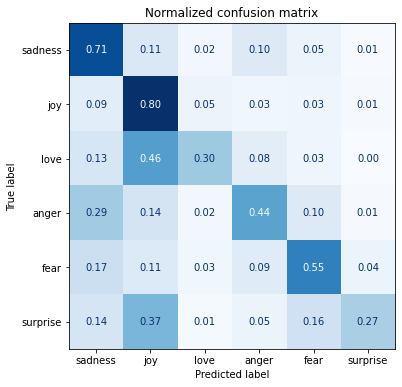

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  plt.show()

labels = emotions['train'].features['label'].names

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

---

### Transformerのファインチューニング

- 隠れ状態を固定的な特徴量として扱わず、全てのモデルパラメータを学習させる
  - 隠れ状態を学習することで、分類タスクにあまり適していないデータを扱わなくて済む
  - 初期の隠れ状態は学習を重ねていくと、今回の分類タスクに適応させられる
- 分類ヘッドの部分が微分可能である必要がある
  - NNで構築


In [59]:
# 事前学習済みモデルの出力の上に分類ヘッドを持っているモデルのため、簡単に学習可
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

#### 性能指標の定義

自作metricsメソッドを定義する

In [61]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average='weighted')

  return {'accuracy': acc, 'f1': f1}

#### モデルの学習

In [63]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [64]:
# ハイパーパラメーターの定義
from transformers import Trainer, TrainingArguments

batch_size = 64
# // 切り捨て除算
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error')

In [67]:
from transformers import Trainer

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

/content/distilbert-base-uncased-finetuned-emotion is already a clone of https://huggingface.co/komekami/distilbert-base-uncased-finetuned-emotion. Make sure you pull the latest changes with `repo.git_pull()`.


In [68]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.188700,0.180621,0.929500,0.929274
2,0.124500,0.159893,0.934000,0.934142


TrainOutput(global_step=500, training_loss=0.156611385345459, metrics={'train_runtime': 242.9014, 'train_samples_per_second': 131.741, 'train_steps_per_second': 2.058, 'total_flos': 720342861696000.0, 'train_loss': 0.156611385345459, 'epoch': 2.0})

In [69]:
preds_output = trainer.predict(emotions_encoded['validation'])

print(preds_output.metrics)

{'test_loss': 0.1598930060863495, 'test_accuracy': 0.934, 'test_f1': 0.9341415823944494, 'test_runtime': 5.506, 'test_samples_per_second': 363.238, 'test_steps_per_second': 5.812}


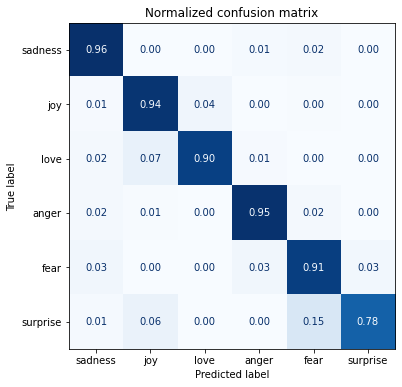

In [70]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

#### エラー分析

In [71]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # すべての入力テンソルをモデルと同じデバイスに配置する
  inputs = {key: value.to(device) for key, value in batch.items() if key in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

  # データセットの他の列との互換性を保つため、出力をCPU上に配置する
  return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}

In [72]:
# データセットをPyTorchのテンソルに変換
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# lossを計算
emotions_encoded['validation'] = emotions_encoded['validation'].map(
    forward_pass_with_label, batched=True, batch_size=16
)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [74]:
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = (df_test['predicted_label'].apply(label_int2str))

In [75]:
df_test.sort_values('loss', ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.773665
1509,i guess this is a memoir so it feels like that...,joy,fear,7.065316
1111,im lazy my characters fall into categories of ...,joy,fear,6.565850
1963,i called myself pro life and voted for perry w...,joy,sadness,6.474190
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.929809
882,i feel badly about reneging on my commitment t...,love,sadness,5.908367
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.876284
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.627673
1840,id let you kill it now but as a matter of fact...,joy,fear,5.334145
1274,i am going to several holiday parties and i ca...,joy,sadness,5.238091


In [76]:
df_test.sort_values('loss', ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.002541
669,i am not feeling very joyful today its been a ...,joy,joy,0.002584
1147,i type i feel bouncy and excited to get out my...,joy,joy,0.002610
222,i am at day and i am feeling terrific,joy,joy,0.002630
1561,i came to tv stations for first debut stage i ...,joy,joy,0.002641
268,i did though and woke up feeling terrific,joy,joy,0.002686
329,i have had my treasury selection on the front ...,joy,joy,0.002689
19,i had lunch with an old friend and it was nice...,joy,joy,0.002695
578,i got to christmas feeling positive about the ...,joy,joy,0.002702
1694,i cant even believe that i have reached a half...,joy,joy,0.002722


In [77]:
trainer.push_to_hub(commit_message='Study FineTuning')

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Nov05_11-09-22_93771d1acb73/events.out.tfevents.1667646872.93771d1acb73.77.2:  64%|######3   …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/komekami/distilbert-base-uncased-finetuned-emotion
   631a0c9..8a74fec  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/komekami/distilbert-base-uncased-finetuned-emotion
   631a0c9..8a74fec  main -> main

To https://huggingface.co/komekami/distilbert-base-uncased-finetuned-emotion
   8a74fec..2b62eb6  main -> main

   8a74fec..2b62eb6  main -> main



'https://huggingface.co/komekami/distilbert-base-uncased-finetuned-emotion/commit/8a74fec5e6956fccd6904482bc99e07e9ecd4771'

In [79]:
from transformers import pipeline

model_id = 'komekami/distilbert-base-uncased-finetuned-emotion'
classifier = pipeline('text-classification', model=model_id)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [80]:
custom_tweet = 'I saw a movie today and it was really good.'
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:92: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  UserWarning,


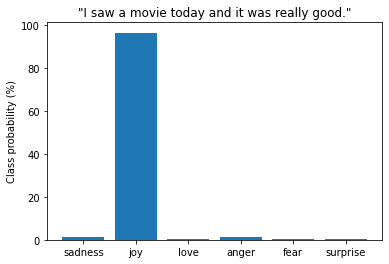

In [83]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df['score'], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel('Class probability (%)')
plt.show()